# Capstone Project - Inventory Monitoring at Distribution Centers
The objective of this project is to design, implement and deploy a CNN classification model which helps robots at distribution centers to count how many objects a bin has. Data used for doing this task is the [*Amazon Image Bin Dataset*](https://registry.opendata.aws/amazon-bin-imagery), this dataset comprises 500.000 images, each of them is associated with a metadata file that has information about the objects in the bin and their characteristics. In this exercise we are going to focus in identifying the number of objects in the bin just by showing the image to the model.

In [ ]:
# TODO: Install any packages that you might need

In [ ]:
# TODO: Import any packages that you might need
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

from sagemaker.debugger import Rule, ProfilerRule

from tqdm import tqdm
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import math


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [5]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('data_subset', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

  0%|          | 1/1228 [00:00<02:46,  7.39it/s]

  0%|          | 1/2299 [00:00<04:23,  8.71it/s]

  0%|          | 2/2666 [00:00<02:48, 15.84it/s]

  0%|          | 2/2373 [00:00<02:37, 15.01it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [02:49<00:00, 11.05it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

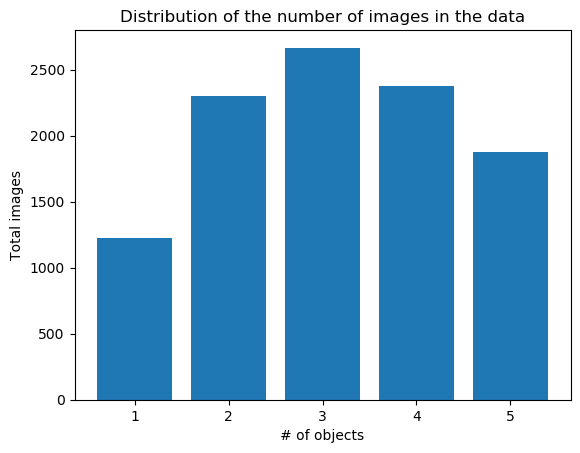

In [122]:
#TODO: Perform any data cleaning or data preprocessing
data_subset_directory = "data_subset"
quantities = os.listdir(data_subset_directory)
quantities.sort()
total_images_by_qty = []
for qty in quantities:
    total_images_by_qty.append(len(os.listdir(os.path.join(data_subset_directory, qty))))

df_qty = pd.DataFrame({"quantity":quantities, "total_images":total_images_by_qty})
df_qty = df_qty.sort_values("quantity")

plt.bar(df_qty['quantity'], df_qty['total_images'])
plt.ylabel("Total images")
plt.xlabel("# of objects")
plt.title("Distribution of the number of images in the data")
plt.show()

### Spliting data into train and test set

In [123]:
!find data_subset/5 -type f | wc -l
!find splitted_data/train/5 -type f | wc -l
!find splitted_data/test/5 -type f | wc -l

1881
1314
561


In [125]:
if not os.path.exists(data_splitted_directory):
    os.makedirs(data_splitted_directory)
if not os.path.exists(os.path.join(data_splitted_directory, "train")):
    os.makedirs(os.path.join(data_splitted_directory, "train"))
if not os.path.exists(os.path.join(data_splitted_directory, "test")):
    os.makedirs(os.path.join(data_splitted_directory, "test"))

In [126]:
from random import sample
import shutil

train_percentage = 0.7
data_splitted_directory = "splitted_data"


for qty in quantities:
    total_images = len(os.listdir(os.path.join(data_subset_directory, qty)))
    print("Processing {} images with {} objects".format(total_images, qty))
    n_training_images = math.ceil(total_images*train_percentage)
    n_testing_images = total_images - n_training_images
    
    print("\tsplitting {} images for training and {} for test...".format(n_training_images, n_testing_images))
    image_names = os.listdir(os.path.join(data_subset_directory, qty))
    if ".ipynb_checkpoints" in image_names:
        image_names.remove(".ipynb_checkpoints")
    train_images = sample(image_names, n_training_images)
    test_images = [x for x in image_names if x not in train_images]
    
    
        
    if not os.path.exists(os.path.join(data_splitted_directory, "train", qty)):
        os.makedirs(os.path.join(data_splitted_directory, "train", qty))
    print("\t\tcopying {} train images...".format(str(len(train_images))))
    for img in train_images:
        shutil.copyfile(os.path.join(data_subset_directory, qty, img), os.path.join(data_splitted_directory, "train", qty, img))
    
    if not os.path.exists(os.path.join(data_splitted_directory, "test", qty)):
        os.makedirs(os.path.join(data_splitted_directory, "test", qty))
    print("\t\tcopying {} test images...".format(str(len(test_images))))
    for img in test_images:
        shutil.copyfile(os.path.join(data_subset_directory, qty, img), os.path.join(data_splitted_directory, "test", qty, img))
    


Processing 1228 images with 1 objects
	splitting 860 images for training and 368 for test...
		copying 860 train images...
		copying 368 test images...
Processing 2299 images with 2 objects
	splitting 1610 images for training and 689 for test...
		copying 1610 train images...
		copying 689 test images...
Processing 2666 images with 3 objects
	splitting 1867 images for training and 799 for test...
		copying 1867 train images...
		copying 799 test images...
Processing 2373 images with 4 objects
	splitting 1662 images for training and 711 for test...
		copying 1662 train images...
		copying 711 test images...
Processing 1876 images with 5 objects
	splitting 1314 images for training and 562 for test...
		copying 1314 train images...
		copying 561 test images...


In [2]:
!du -hs splitted_data/*

182M	splitted_data/test
426M	splitted_data/train


In [2]:
#TODO: Upload the data to AWS S3
!aws s3 cp splitted_data/ s3://inventory-monitoring-udacity/data/ --recursive

upload: splitted_data/test/1/00024.jpg to s3://inventory-monitoring-udacity/data/test/1/00024.jpg
upload: splitted_data/test/1/00148.jpg to s3://inventory-monitoring-udacity/data/test/1/00148.jpg
upload: splitted_data/test/1/00312.jpg to s3://inventory-monitoring-udacity/data/test/1/00312.jpg
upload: splitted_data/test/1/00100.jpg to s3://inventory-monitoring-udacity/data/test/1/00100.jpg
upload: splitted_data/test/1/00423.jpg to s3://inventory-monitoring-udacity/data/test/1/00423.jpg
upload: splitted_data/test/1/00352.jpg to s3://inventory-monitoring-udacity/data/test/1/00352.jpg
upload: splitted_data/test/1/00014.jpg to s3://inventory-monitoring-udacity/data/test/1/00014.jpg
upload: splitted_data/test/1/00418.jpg to s3://inventory-monitoring-udacity/data/test/1/00418.jpg
upload: splitted_data/test/1/00488.jpg to s3://inventory-monitoring-udacity/data/test/1/00488.jpg
upload: splitted_data/test/1/00470.jpg to s3://inventory-monitoring-udacity/data/test/1/00470.jpg
upload: splitted_dat

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [5]:
sess = sagemaker.Session()
bucket = sess.default_bucket()                    # Set a default S3 bucket
prefix = 'deep-learning-models-on-sagemaker-project'
role = sagemaker.get_execution_role()
sess, bucket, role

(<sagemaker.session.Session at 0x7f9dca8d3c10>,
 'sagemaker-us-east-1-718269677396',
 'arn:aws:iam::718269677396:role/service-role/AmazonSageMaker-ExecutionRole-20221129T185952')

In [6]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "momentum": ContinuousParameter(0.1, 0.9),
    "batch-size": CategoricalParameter([8, 16, 32, 64]),
}

In [18]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: (\-?[0-9\\.]+)"}]

tuner = tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=9,
    max_parallel_jobs=3,
    objective_type=objective_type,
)
s3_data = "s3://inventory-monitoring-udacity/data/"

In [19]:
# TODO: Fit your estimator
tuner.fit({"training":s3_data}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [20]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2022-12-05 23:41:24 Starting - Found matching resource for reuse
2022-12-05 23:41:24 Downloading - Downloading input data
2022-12-05 23:41:24 Training - Training image download completed. Training in progress.
2022-12-05 23:41:24 Uploading - Uploading generated training model
2022-12-05 23:41:24 Completed - Resource reused by training job: pytorch-training-221205-2200-007-4fbd90a5


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'lr': '0.0074914916324585025',
 'momentum': '0.28972666789587076',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-12-05-22-00-28-236"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-718269677396/pytorch-training-2022-12-05-22-00-28-236/source/sourcedir.tar.gz"'}

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [34]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data='s3://sagemaker-us-east-1-718269677396/pytorch-training-221205-2200-004-ac51a144/output/model.tar.gz', 
                             role=role, 
                             entry_point='inference.py', 
                             framework_version="1.8", 
                             py_version="py36",)

predictor = pytorch_model.deploy(instance_type='ml.m5.large', initial_instance_count=1)

------!

In [33]:
predictor.delete_endpoint()

In [47]:
from sagemaker.serializers import IdentitySerializer
predictor.serializer = IdentitySerializer("image/jpeg")
from PIL import Image
from IPython.display import Image as ImageDisplay
import io
import numpy as np

image = 'splitted_data/test/4/00118.jpg'
buf = io.BytesIO()
Image.open(image).save(buf, format="JPEG")

### Running multiple predictions to stress the endpoint

In [48]:
# TODO: Run an prediction on the endpoint
for i in range(0,100000): 
    print("\rMaking {}/100000 predictions".format(i), end="")
    response = predictor.predict(buf.getvalue())
    np.argmax(response, 1)

Making 9131/100000 predictions

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint pytorch-inference-2022-12-06-01-07-07-486 of account 718269677396 not found.

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances